In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_arch

# Read data from file
df = pd.read_csv('df.csv', sep=',')

In [2]:
# turn off settingwithcopy warning
pd.options.mode.chained_assignment = None

In [3]:
df.head(3)

,country_name,growth,rgdp60,tradeshare,yearsschool,rev_coups,assasinations
0,India,1.915168,765.9998,0.140502,1.45,0.133333,0.866667
1,Argentina,0.617645,4462.0010,0.156623,4.99,0.933333,1.933333
2,Japan,4.304759,2954.0000,0.157703,6.71,0.000000,0.200000


In [4]:
df.drop('country_name', axis=1, inplace=True)

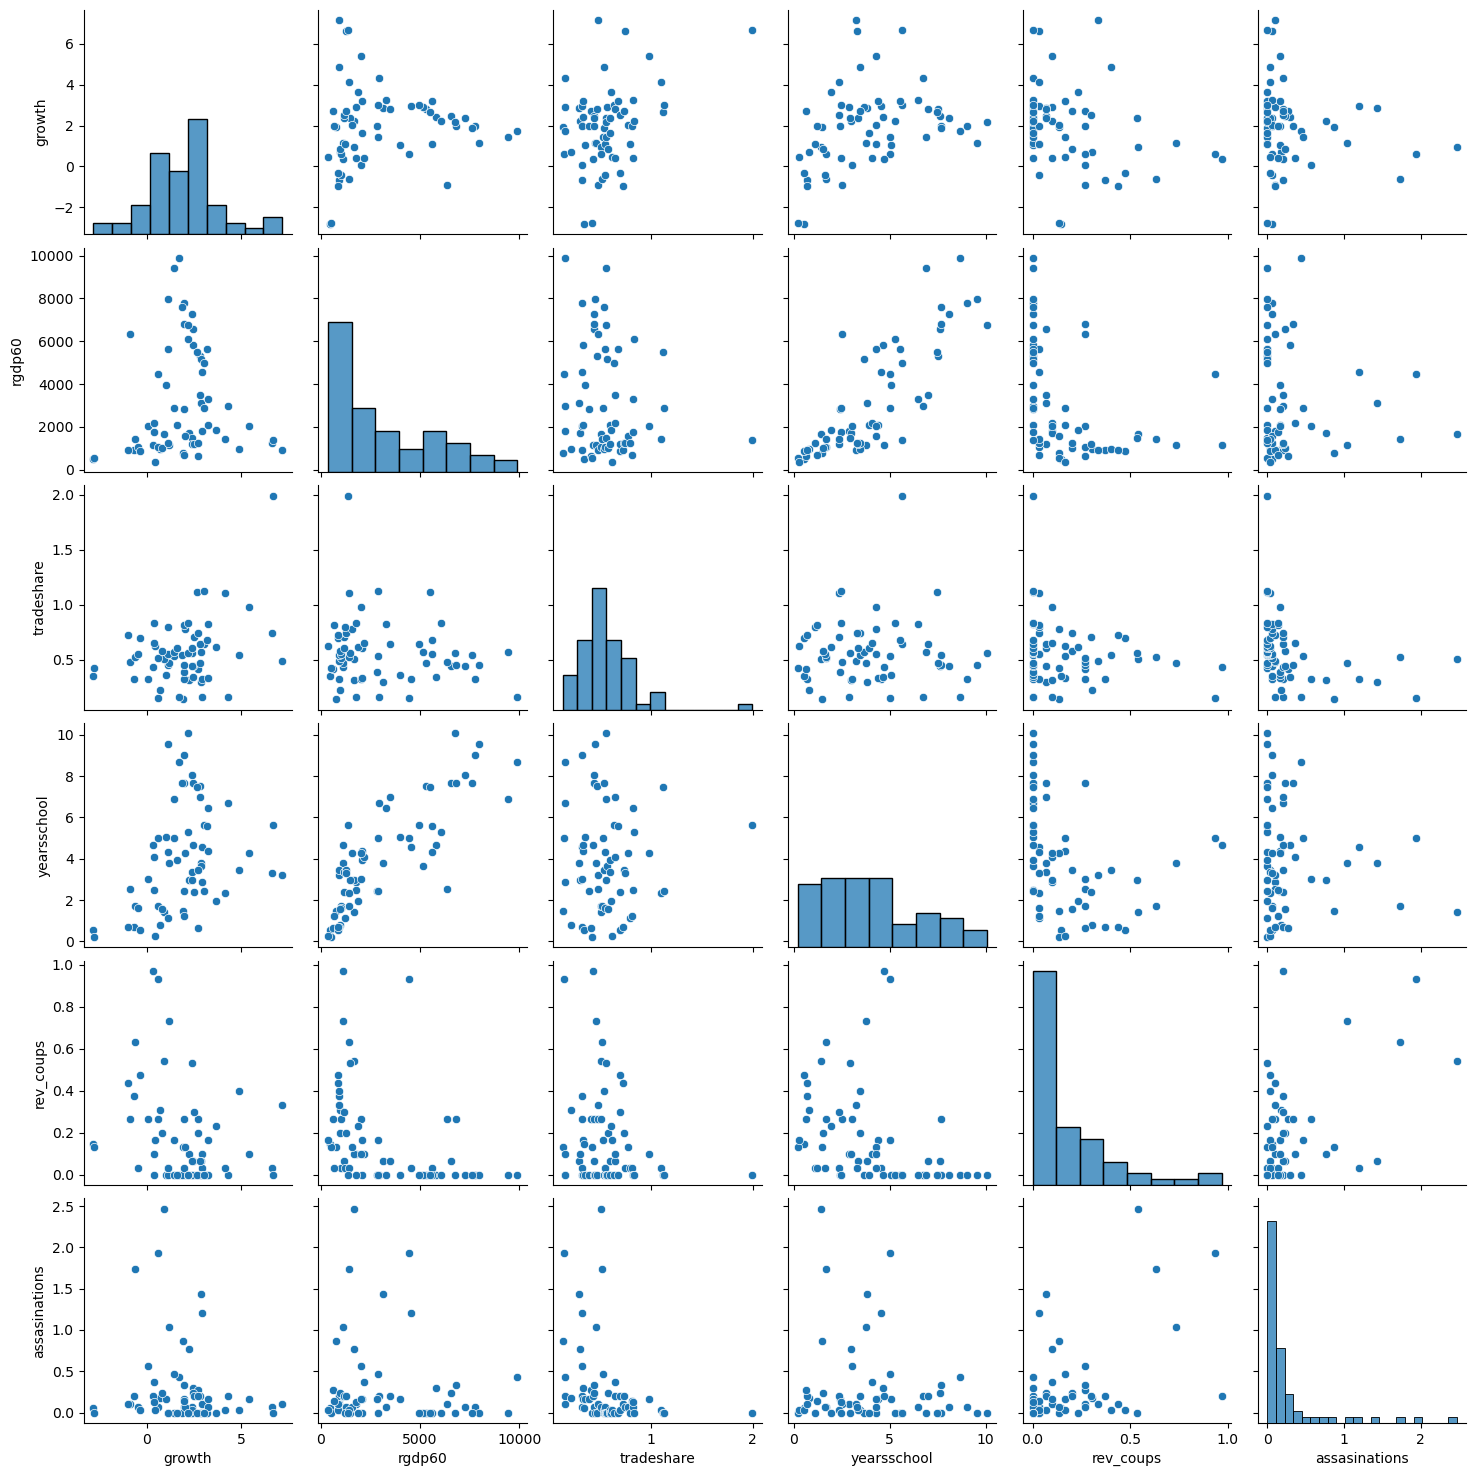

In [5]:
# plot pairplot
sns.pairplot(df,palette='husl')
plt.show()

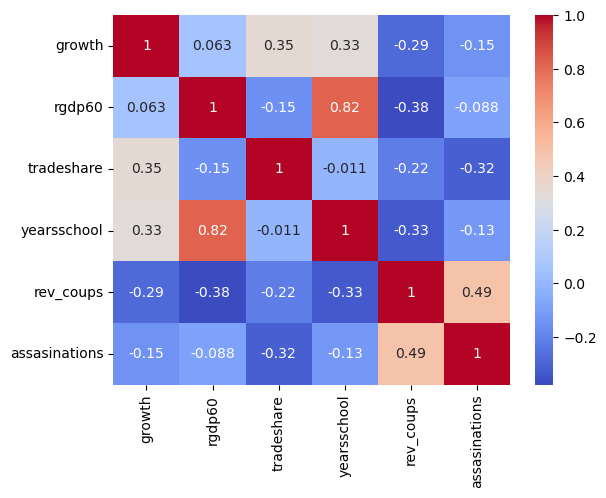

In [6]:
# plot corelation matrix with annot
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
# check for multicollinearity
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["features"] = df.columns
vif

,VIF Factor,features
0,3.193650,growth
1,9.783748,rgdp60
2,3.285123,tradeshare
3,14.332030,yearsschool
4,2.108344,rev_coups
5,1.819256,assasinations


In [8]:
# check assumptions for linear regression
# normality
# Shapiro-Wilk test
# H0: data is normally distributed
# H1: data is not normally distributed
for col in df.columns:
    p = stats.shapiro(df[col])[1]
    if p < 0.05:
        print(f'Reject H0, {col} is not normally distributed')
    else:
        print(f'Accept H0, {col} is normally distributed')
    

Reject H0, growth is not normally distributed
Reject H0, rgdp60 is not normally distributed
Reject H0, tradeshare is not normally distributed
Reject H0, yearsschool is not normally distributed
Reject H0, rev_coups is not normally distributed
Reject H0, assasinations is not normally distributed


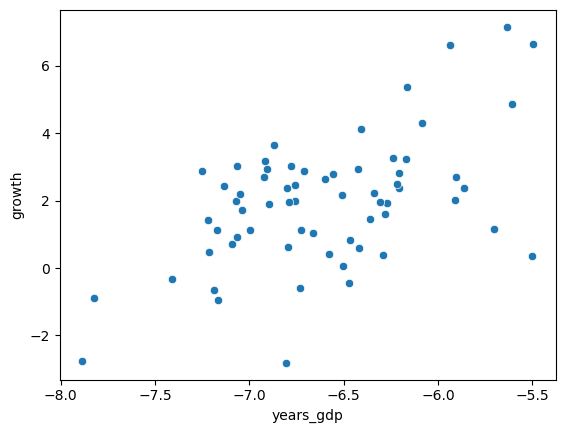

In [9]:
# combine multicolinear variables
df['years_gdp'] = np.log(df['yearsschool'] / df['rgdp60'])
# scatterplot
sns.scatterplot(x='years_gdp', y='growth', data=df)
plt.show()

# drop multicolinear variables
df.drop(['yearsschool', 'rgdp60'], axis=1, inplace=True)

In [10]:
# fit olsm model
model = ols('growth ~ years_gdp + tradeshare + rev_coups ', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     16.75
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           4.75e-08
Time:                        01:19:38   Log-Likelihood:                -113.82
No. Observations:                  65   AIC:                             235.6
Df Residuals:                      61   BIC:                             244.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.2907      2.567      5.957      0.0

In [11]:
# fit glm model
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gaussian
model = GLM.from_formula('growth ~ years_gdp + tradeshare + rev_coups ', data=df, family=Gaussian()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 growth   No. Observations:                   65
Model:                            GLM   Df Residuals:                       61
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          2.0706
Method:                          IRLS   Log-Likelihood:                -113.82
Date:                Fri, 09 Dec 2022   Deviance:                       126.31
Time:                        01:19:38   Pearson chi2:                     126.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5393
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.2907      2.567      5.957      0.0

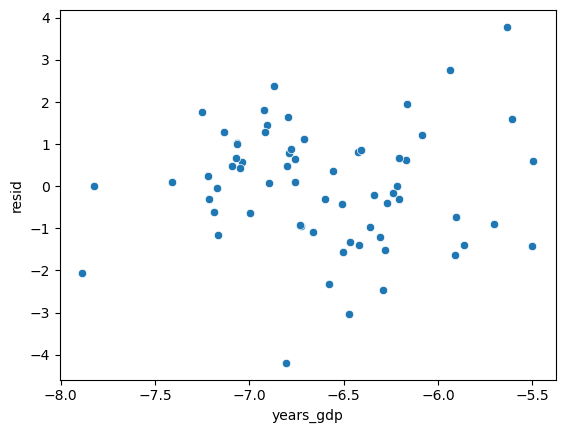

In [12]:
# studentize residuals
df['resid'] = model.resid_pearson
# plot residuals
sns.scatterplot(x='years_gdp', y='resid', data=df)
plt.show()
